In [1]:
using PyCall, PyPlot, JuMP
using ClimateMARGO

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1273
┌ Info: Precompiling ClimateMARGO [d3f62095-a717-45bf-aadc-ac9dfc258fa6]
└ @ Base loading.jl:1273


In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");
rcParams["lines.linestyle"] = "-";


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded

Control re-adjustments due to passage of time
Solve_Succeeded
NPV: 196.37856891045348 - 201.79215923555805 = -5.413590325104565
T = 2.0000000012387753 to 2.0000000013232775
Solve_Succeeded
NPV: 189.66210843462557 - 199.99199239020967 = -10.329883955584108
T = 2.0000000013232775 to 2.0000000177531514

Response to variability in baseline emissions
Solve_Succeeded
Solve_Succeeded
NPV: 186.8925918902894 - 201.79215923555805 = -14.89956734526865
T = 1.9416930609373675 to 2.000000000807207
Solve_Succeeded
Solve_Succeeded
NPV: 200.05694718879687 - 189.5838989574466 = 10.473048231350276
T = 2.095

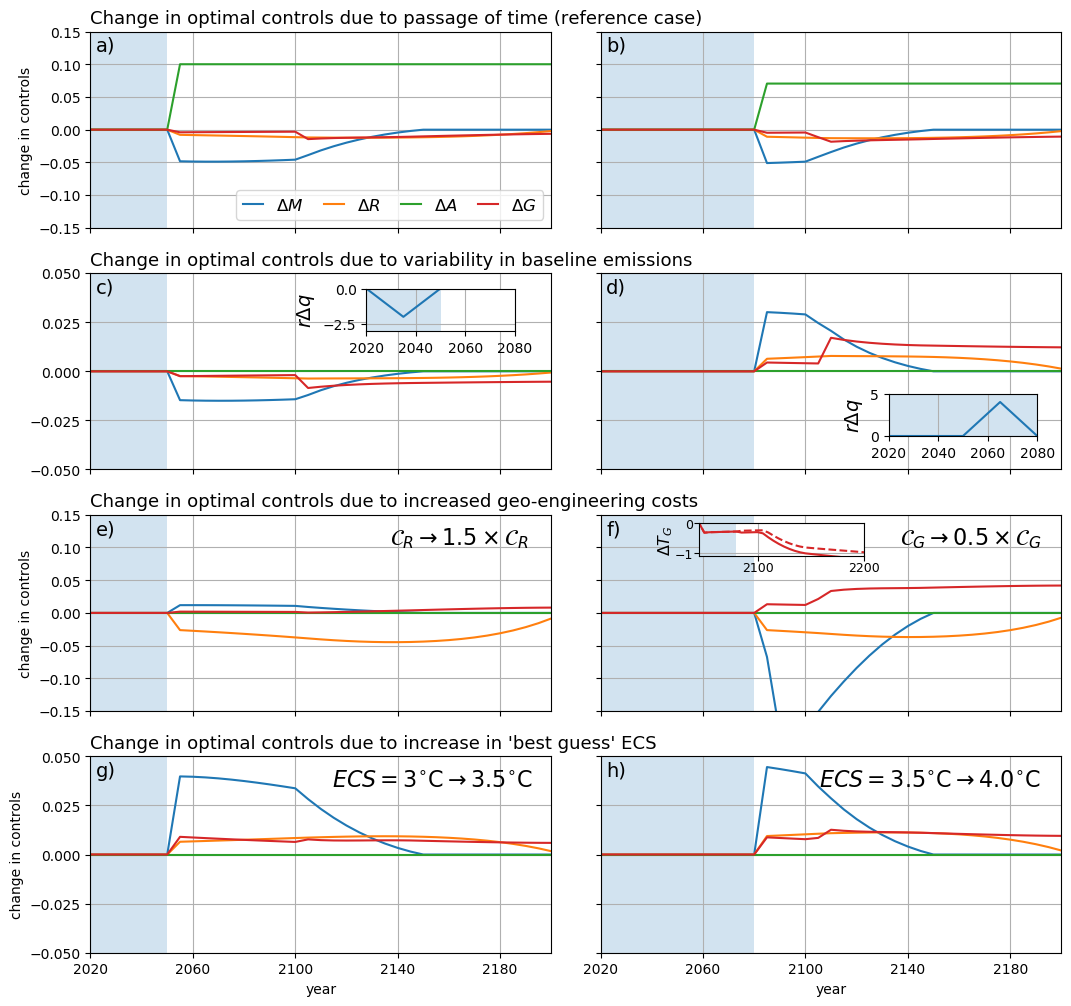

Infeasible_Problem_Detected
Solve_Succeeded
NPV: 569.9404253452859 - 180.121088595443 = 389.81933674984293
T = 2.2283775137246122 to 2.193891903811235


In [3]:
control_dict = Dict()
model_dict = Dict()

model = ClimateModel();
optimize_controls!(model);

Δt = 30.
Δq_samples = [-2., 4.]/model.physics.r

ensemble = Dict()
ensemble[string(Int64(model.present_year))] = deep_copy(model);

fig = figure(figsize=(11,10))
ylims = [-0.15, 0.15]

print("\nControl re-adjustments due to passage of time\n")
previous_year = deepcopy(model.present_year)
for (n, Δq) in enumerate(Δq_samples)
    control_name = deepcopy(string(Int64(model.present_year + Δt), "_control"))

    # optimize before adding emissions
    control = deep_copy(model)
    control_dict[n] = deep_copy(model)
    step_forward!(control, Δt)

    step_forward!(model, Δt)
    NPV_old = deepcopy(discounted_total_control_cost(model))
    maxT_old = deepcopy(maximum(δT_adapt(model)))

    m = optimize_controls!(model);
    model_dict[n] = deep_copy(model)

    NPV_revised = discounted_total_control_cost(model)
    maxT_revised = maximum(δT_adapt(model))
    NPV_diff = NPV_revised - NPV_old
    print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
    print("T = $maxT_old to $maxT_revised\n")

    # Plotting
    fig.add_subplot(4, length(Δq_samples), n)
    fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
    plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
    plot(model.domain, model.controls.remove .- control.controls.remove)
    plot(model.domain, model.controls.adapt .- control.controls.adapt)
    plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
    xlim([2020, 2200])
    ylim(ylims)
    xlabel("")
    ylabel("")
    locs, labels = xticks()
    xticks(locs, labels=[])
    locs, labels = yticks(-0.15:0.05:0.15)
    if n==2
        locs, labels = yticks()
        yticks(locs, labels=[])
    end
    grid(true)
    
    if n==1
        ylabel("change in controls");
        plot([], [], "C0-", label=L"$\Delta M$")
        plot([], [], "C1-", label=L"$\Delta R$")
        plot([], [], "C2-", label=L"$\Delta A$")
        plot([], [], "C3-", label=L"$\Delta G$")
        legend(loc="lower right", handlelength=1.2, ncol=4, fontsize=12, columnspacing=1.2)
    end
end

model = deep_copy(ensemble["2020"])
print("\nResponse to variability in baseline emissions\n")
previous_year = deepcopy(model.present_year)
for (n, Δq) in enumerate(Δq_samples)
    control_name = deepcopy(string(Int64(model.present_year + Δt), "_control"))

    # optimize before adding emissions
    control = deep_copy(model)
    control_dict[n] = deep_copy(model)
    step_forward!(control, Δt)
    mcontrol = optimize_controls!(control);
    add_emissions_bump!(control, Δt, Δq, present_year = control.present_year - Δt)
    ensemble[control_name] = control
    
    # optimize after adding emissions
    add_emissions_bump!(model, Δt, Δq)
    step_forward!(model, Δt)
    
    NPV_old = deepcopy(discounted_total_control_cost(model))
    maxT_old = deepcopy(maximum(δT_adapt(model)))
    
    m = optimize_controls!(model);
    model_dict[n] = deep_copy(model)

    NPV_revised = discounted_total_control_cost(model)
    maxT_revised = maximum(δT_adapt(model))
    NPV_diff = NPV_revised - NPV_old
    print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
    print("T = $maxT_old to $maxT_revised\n")

    # Plotting
    fig.add_subplot(4, length(Δq_samples), length(Δq_samples)+n)
    fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
    plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
    plot(model.domain, model.controls.remove .- control.controls.remove)
    plot(model.domain, model.controls.adapt .- control.controls.adapt)
    plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
    xlim([2020, 2200])
    ylim(ylims ./ 3.)
    xlabel("")
    ylabel("")
    locs, labels = xticks()
    xticks(locs, labels=[])
    locs, labels = yticks(-0.05:0.025:0.05)
    if n==1
    else
        locs, labels = yticks()
        yticks(locs, labels=[])
    end
    grid(true)
    
    ensemble[model.name] = deep_copy(model);
end

########
print("\nResponse to higher geoengineering costs\n")

model = deep_copy(ensemble["2020"])
step_forward!(model, Δt)
control = deep_copy(model)
cost_control = deep_copy(control)

model.economics.remove_cost *= 1.5
NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.economics.remove_cost *= 1.5

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

t = ClimateMARGO.t
cost_overrun = (
    sum(model.dt * (f(model.controls.remove) * model.economics.remove_cost)[t .< model.present_year]) -
    sum(model.dt * (f(cost_control.controls.remove) * cost_control.economics.remove_cost)[t .< model.present_year])
)
print("Cost overuns: $cost_overrun\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*2+1)
fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("")
ylabel("change in controls")
grid(true)
locs, labels = xticks()
xticks(locs, labels=[])
locs, labels = yticks(-0.15:0.05:0.15)
ylim(ylims)
annotate(s=L"$\mathcal{C}_{R} \rightarrow 1.5 \times \mathcal{C}_{R}$", xy=(0.65, 0.85), xycoords="axes fraction", fontsize=16)

step_forward!(model, Δt)
control = deep_copy(model)
cost_control = deep_copy(control)

model.economics.geoeng_cost *= 0.5

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.economics.geoeng_cost *= 0.5

model_dict["G_control"] = deep_copy(control)
model_dict["G_model"] = deep_copy(model)

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

cost_overrun = (
    sum(model.dt * (f(model.controls.geoeng) .* model.economics.GWP * model.economics.geoeng_cost)[t .< model.present_year]) -
    sum(model.dt * (f(cost_control.controls.geoeng) .* model.economics.GWP * cost_control.economics.geoeng_cost)[t .< model.present_year])
)
print("Cost overuns: $cost_overrun\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*2+2)
fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("")
ylabel("")
grid(true)
locs, labels = xticks()
xticks(locs, labels=[])
locs, labels = yticks(-0.15:0.05:0.15, [])
ylim(ylims)
annotate(s=L"$\mathcal{C}_{G} \rightarrow 0.5 \times \mathcal{C}_{G}$", xy=(0.65, 0.85), xycoords="axes fraction", fontsize=16)

########################################################
########################################################
print("\nResponse to higher climate sensitivity\n")

model = deep_copy(ensemble["2020"])
step_forward!(model, Δt)
control = deep_copy(model)

FCO₂_2x = ClimateMARGO.FCO₂_2x
sec_per_year = ClimateMARGO.sec_per_year

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 0.5)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 0.5)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*3+1)
fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("year")
ylabel("change in controls")
locs, labels = yticks(-0.05:0.025:0.05)
grid(true)
ylim(ylims ./3.)
annotate(s=L"$ECS = 3^{\circ}$C$\rightarrow 3.5^{\circ}$C", xy=(0.525, 0.85), xycoords="axes fraction", fontsize=16)

step_forward!(model, Δt)
control = deep_copy(model)

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.05)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

old_model = deep_copy(model)

m = optimize_controls!(model, temp_goal = 2.0);
m = optimize_controls!(control, temp_goal = 2.0);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.05)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

# Plotting
fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*3+2)
fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)

xlim([2020, 2200])
xlabel("year")
ylabel("")
locs, labels = yticks(-0.05:0.025:0.05, labels=[])
grid(true)
ylim(ylims ./3.)
annotate(s=L"$ECS = 3.5^{\circ}$C$\rightarrow 4.0^{\circ}$C", xy=(0.475, 0.85), xycoords="axes fraction", fontsize=16)

iax = fig.add_axes([0.3375, 0.68, 0.135, 0.0425])
sca(iax)
fill_between([2020, model_dict[1].present_year], [0, 0], [-3, -3], facecolor="C0", alpha=0.2)
plot(model.domain, effective_baseline_emissions(model_dict[1]) - effective_baseline_emissions(control_dict[1]), "C0-")
ylabel(L"$r Δq$", fontsize=14)
grid(true)
xlabel("")
xlim([2020,2080])
ylim([-3, 0])
title("")

iax = fig.add_axes([0.8125, 0.575, 0.135, 0.0425])
sca(iax)
fill_between([2020, model_dict[2].present_year], [0, 0], [5., 5.], facecolor="C0", alpha=0.2)
plot(model.domain, effective_baseline_emissions(model_dict[2]) - effective_baseline_emissions(control_dict[2]), "C0-")
ylabel(L"$r Δq$", fontsize=14)
grid(true)
xlabel("")
xlim([2020,2080])
ylim([0, 5])
title("")

iax = fig.add_axes([0.64, 0.455, 0.15, 0.033])
sca(iax)
fill_between([2020, 2080.], [0, 0], [-1.5, -1.5], facecolor="C0", alpha=0.2)
plot(model.domain, δT(model_dict["G_control"]) .- δT_no_geoeng(model_dict["G_control"]), "C3--")
plot(model.domain, δT(model_dict["G_model"]) .- δT_no_geoeng(model_dict["G_model"]), "C3-")
ylabel(L"$\Delta T_{G}$", fontsize=11.5, labelpad=0.25)
grid(true)
xlabel("")
tick_params(pad=0.5)
xticks(fontsize=9.)
yticks(fontsize=9.)
xlim([2045, 2200])
ylim([-1.1, 0.])
title("")

labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]
for n = 1:8
    fig.add_subplot(4, 2, n)
    annotate(s=labels[n], xy=(0.0125, 0.9), xycoords="axes fraction", fontsize=14)
    xticks(2020:40:2200)
end

tight_layout(h_pad=2.25)

fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*0+1)
tit = title("Change in optimal controls due to passage of time (reference case)", loc="left", fontsize=13)

fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*1+1)
tit = title("Change in optimal controls due to variability in baseline emissions", loc="left", fontsize=13)

fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*2+1)
tit = title("Change in optimal controls due to increased geo-engineering costs", loc="left", fontsize=13)

fig.add_subplot(4, length(Δq_samples), length(Δq_samples)*3+1)
tit = title("Change in optimal controls due to increase in 'best guess' ECS", loc="left", fontsize=13)

#savefig("../figures/policy_updates.pdf", dpi=150, bbox_inches="tight")

model = deep_copy(ensemble["2020"])
step_forward!(model, 3*Δt)
control = deep_copy(model)

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.05)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

m = optimize_controls!(model, temp_goal = 2.0);
m = optimize_controls!(control, temp_goal = 2.0);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.05)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

### Testing limits of the policy response process

In [4]:
model = deep_copy(ensemble["2020"])
step_forward!(model, 80.)
control = deep_copy(model)

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.05)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

temp_goal = 2.2

m = optimize_controls!(model, temp_goal = temp_goal);
m = optimize_controls!(control, temp_goal = temp_goal);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.05)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

Solve_Succeeded
Solve_Succeeded
NPV: 174.91594842454896 - 191.41051878528853 = -16.494570360739573
T = 2.2283775137246122 to 2.2000000011581724
